### Imports & Preparation

In [11]:
import sys
sys.path.insert(1, '../../')  # to load from any submodule in the repo

import utils.dpcr_utils as utils
import utils.dpcr_generator as generator
import utils.readOBJ as reader

import os
import numpy as np
import torch
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cpu")

if torch.device("cuda"):
    device = torch.device("cuda")
    print("Using", torch.cuda.device_count(), "CUDA devices")

seed_file = open('../../utils/seed.txt', "r")
seed = int(seed_file.read())
seed_file.close()

print ("Using Seed:", seed)

torch.manual_seed(seed)
np.random.seed(seed)

Using 1 CUDA devices
Using Seed: 34897567


In [21]:
import torch.cuda

print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())
print(torch.cuda.memory_allocated() / 10**9)

GeForce GTX 1070
(6, 1)
0.212924416


In [2]:
TRAIN_SET_SIZE = 10
TEST_SET_SIZE = int(0.1 * TRAIN_SET_SIZE)
VAL_SET_SIZE = int(0.5 * TRAIN_SET_SIZE)

OUTPUT_DIRECTORY = '../../data/train_test_data_new'
TRAIN_DATA_NAME = 'train_data_test_239875z289376'

## Generate

Load Model(s) from .obj file and generate raw training data

In [3]:
models = []
train_data = []
knn = []

start_id = 0

for i in range(1,11):
    
    print ("Processing model %02d.." % (i))
    
    start = time.time()
    
    model, _ = reader.readOBJ("../../data/models/faces/clean/face_%02d_clean.obj" % (i))
    
    model = torch.from_numpy(model).float().to(device)
    
    # mean centering
    model = model - torch.mean(model, dim = 0)
    
    # scaling to fit 2x2x2 bounding box
    min_vals, _ = torch.min(model, dim = 0)
    max_vals, _ = torch.max(model, dim = 0)
    scale = torch.max(torch.abs(min_vals),  torch.abs(max_vals))
    model = model / scale
    
    models.append(model)
    
    knn.append(utils.knn(model, 6) + start_id)
    
    for sample in generator.getData(model, TRAIN_SET_SIZE):
    
        sample[:, 0] += start_id
        train_data.append(sample)
    
    print ("   ..done! (%.1fs)" % (time.time() - start))
    
    start_id += model.size(0)
    
    
pts = torch.cat(models)
knn = torch.cat(knn)

print ("\n#Train Samples: %d" % len(train_data))

data = {
    "pts": pts,
    "knn": knn,
    "train_bins": None,
    "test_samples": None
}

Processing model 01..
   ..done! (4.6s)
Processing model 02..
   ..done! (2.7s)
Processing model 03..
   ..done! (2.9s)
Processing model 04..
   ..done! (2.8s)
Processing model 05..
   ..done! (2.8s)
Processing model 06..
   ..done! (2.8s)
Processing model 07..
   ..done! (3.0s)
Processing model 08..
   ..done! (2.9s)
Processing model 09..
   ..done! (2.9s)
Processing model 10..
   ..done! (2.8s)

#Train Samples: 808


237
(6723, 3)


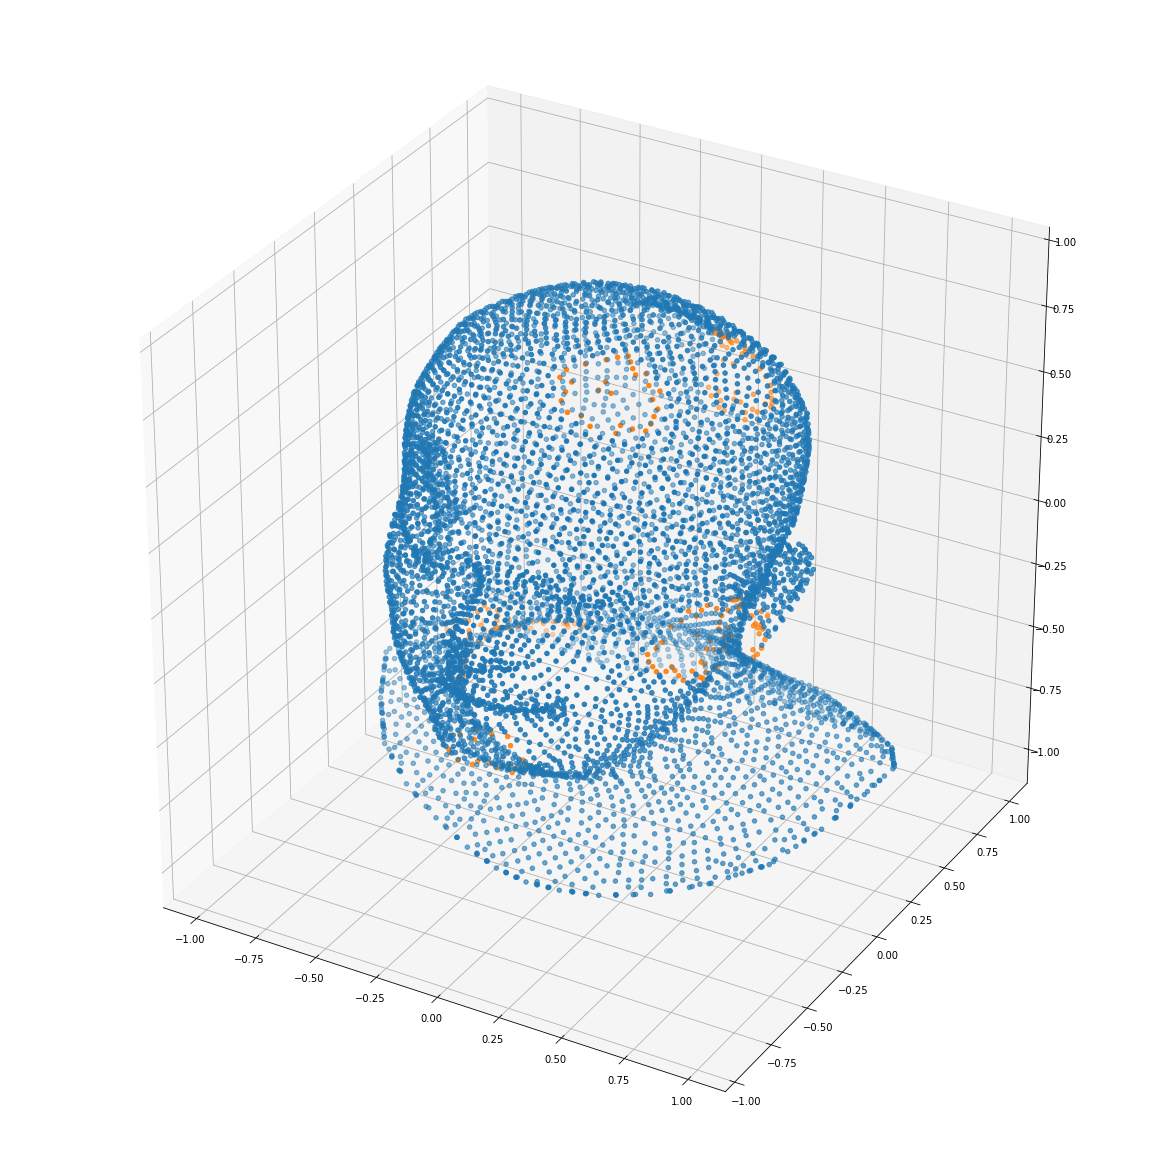

In [4]:
i = np.random.randint(0, len(train_data))

sample_Vind = train_data[i][:,0]
sample_Emask = train_data[i][:,1]

fig = plt.figure(figsize=(16,16))
ax = Axes3D(fig)

edge_pts = pts[sample_Vind][sample_Emask == 1].cpu().numpy()
non_edge_pts = pts[sample_Vind][sample_Emask == 0].cpu().numpy()

print (torch.sum(sample_Emask).item())
print (non_edge_pts.shape)

ax.scatter(non_edge_pts[:,0], non_edge_pts[:,1], non_edge_pts[:,2])
ax.scatter(edge_pts[:,0], edge_pts[:,1], edge_pts[:,2])


plt.show()

In [5]:
start = time.time()

train_bins = [bin.to(device) for bin in utils.getBins([sample.size(0) for sample in train_data], b=50)]
train_bins_sub = [[] for bin in train_bins]

print("\nBinning Results:")

for (i, bin) in enumerate(train_bins):

    size_list = [train_data[sample_id].size(0) for sample_id in bin]
    min_lim, max_lim = min(size_list), max(size_list)

    print("Bin %03d: %4d samples (sized %4d to %4d) [%.4f min. sample rate]" % ((i+1), train_bins[i].size(0), min_lim, max_lim, min_lim / max_lim))
    
    train_bins_sub[i] = torch.zeros((bin.size(0), min_lim, 2), dtype=torch.long, device=device)
    
    for (j, sample_id) in enumerate(bin):

        sample = train_data[sample_id.item()]
        
        Vidx = sample[:, 0]
        Emask = sample[:, 1]
        
        # compute sample ratio (percentage of how many points from sample are kept)
        subsample_ratio = min_lim / size_list[j]

        # compute number of points in sample that are from either class 0 or class 1
        c1_samples = torch.sum(Emask).item()
        c0_samples = size_list[j] - c1_samples

        # compute exact number of points per class in subsample (note: c1 is preferred, since it usually is the smaller class)
        c1_subsamples = int(np.ceil(c1_samples * subsample_ratio))
        c0_subsamples = min_lim - c1_subsamples

        # get random id's of c1 and c0 subsamples
        idx = torch.arange(0, size_list[j], dtype=torch.long, device=device)
        rand_c1_idx = idx[Emask == 1][torch.randperm(c1_samples, device=device)[:c1_subsamples]]
        rand_c0_idx = idx[Emask == 0][torch.randperm(c0_samples, device=device)[:c0_subsamples]]
        
        # create sub-sample mask
        sub_sampled_idx = torch.zeros(size_list[j], dtype=torch.uint8, device=device)
        sub_sampled_idx[rand_c1_idx] = 1
        sub_sampled_idx[rand_c0_idx] = 1

        train_bins_sub[i][j, :, :] = sample[sub_sampled_idx == 1, :]
        
data["train_bins"] = train_bins_sub
        
print ("\nTotal Binning Time: %.1fs" % (time.time() - start))


Binning Results:
Bin 001:   17 samples (sized 3461 to 4753) [0.7282 min. sample rate]
Bin 002:   16 samples (sized 4761 to 5106) [0.9324 min. sample rate]
Bin 003:   16 samples (sized 5107 to 5379) [0.9494 min. sample rate]
Bin 004:   16 samples (sized 5394 to 5540) [0.9736 min. sample rate]
Bin 005:   16 samples (sized 5548 to 5694) [0.9744 min. sample rate]
Bin 006:   16 samples (sized 5708 to 5811) [0.9823 min. sample rate]
Bin 007:   17 samples (sized 5815 to 5967) [0.9745 min. sample rate]
Bin 008:   16 samples (sized 5987 to 6040) [0.9912 min. sample rate]
Bin 009:   16 samples (sized 6043 to 6147) [0.9831 min. sample rate]
Bin 010:   16 samples (sized 6152 to 6238) [0.9862 min. sample rate]
Bin 011:   16 samples (sized 6241 to 6287) [0.9927 min. sample rate]
Bin 012:   16 samples (sized 6292 to 6343) [0.9920 min. sample rate]
Bin 013:   17 samples (sized 6344 to 6439) [0.9852 min. sample rate]
Bin 014:   16 samples (sized 6442 to 6501) [0.9909 min. sample rate]
Bin 015:   16 sa

In [6]:
start_id = 0

test_data = []
knn = []

for (i, model) in enumerate(models):
    
    print ("Processing model %02d.." % (i+1))
    
    start = time.time()
    
    for sample in generator.getData(model, TEST_SET_SIZE):
    
        sample[:, 0] += start_id
        test_data.append(sample)
    
    print ("   ..done! (%.4fs)" % (time.time() - start))
    
    start_id += model.size(0)
    
data["test_samples"] = test_data
    
print ("\n#Test Samples: %d" % len(test_data))

Processing model 01..
   ..done! (0.2480s)
Processing model 02..
   ..done! (0.2410s)
Processing model 03..
   ..done! (0.2505s)
Processing model 04..
   ..done! (0.2380s)
Processing model 05..
   ..done! (0.2545s)
Processing model 06..
   ..done! (0.2500s)
Processing model 07..
   ..done! (0.2520s)
Processing model 08..
   ..done! (0.2595s)
Processing model 09..
   ..done! (0.2670s)
Processing model 10..
   ..done! (0.2505s)

#Test Samples: 74


In [7]:
val_models = []
val_samples = []
val_knn = []

start_id = 0

for i in range(11,13):
    
    print ("Processing model %02d.." % (i))
    
    start = time.time()
    
    val_model, _ = reader.readOBJ("../../data/models/faces/clean/face_%02d_clean.obj" % (i))
    val_model = torch.from_numpy(val_model).float().to(device)
    
    # mean centering
    val_model = val_model - torch.mean(val_model, dim = 0)
    
    # scaling to fit 2x2x2 bounding box
    min_vals, _ = torch.min(val_model, dim = 0)
    max_vals, _ = torch.max(val_model, dim = 0)
    scale = torch.max(torch.abs(min_vals),  torch.abs(max_vals))
    val_model = val_model / scale
    
    val_models.append(val_model)
    
    val_knn.append(utils.knn(val_model, 6) + start_id)
    
    for sample in generator.getData(val_model, VAL_SET_SIZE):
    
        sample[:, 0] += start_id
        val_samples.append(sample)
    
    print ("   ..done! (%.1fs)" % (time.time() - start))
    
    start_id += val_model.size(0)
    
    
data["val_pts"] = torch.cat(val_models)
data["val_knn"] = torch.cat(val_knn)
data["val_samples"] = val_samples

print ("\n#Validation Samples: %d" % len(val_samples))

Processing model 11..
   ..done! (1.5s)
Processing model 12..
   ..done! (1.5s)

#Validation Samples: 85


In [8]:
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

#with open(OUTPUT_DIRECTORY + '/' + TRAIN_DATA_NAME, 'wb') as file:
#    cPickle.dump(data, file)

with open(OUTPUT_DIRECTORY + '/' + TRAIN_DATA_NAME, 'wb') as file:
    torch.save(data, file)

## Load & Test Train Data

In [9]:
start = time.time()

data = None
#with open(OUTPUT_DIRECTORY + '/' + TRAIN_DATA_NAME, 'rb') as file:
#    data = cPickle.load(file)

with open(OUTPUT_DIRECTORY + '/' + TRAIN_DATA_NAME, 'rb') as file:
    data = torch.load(file)
    
print ("Total Time: ", time.time() - start)

Total Time:  0.08999800682067871


torch.cuda.LongTensor
torch.cuda.LongTensor
593
(4801, 3)


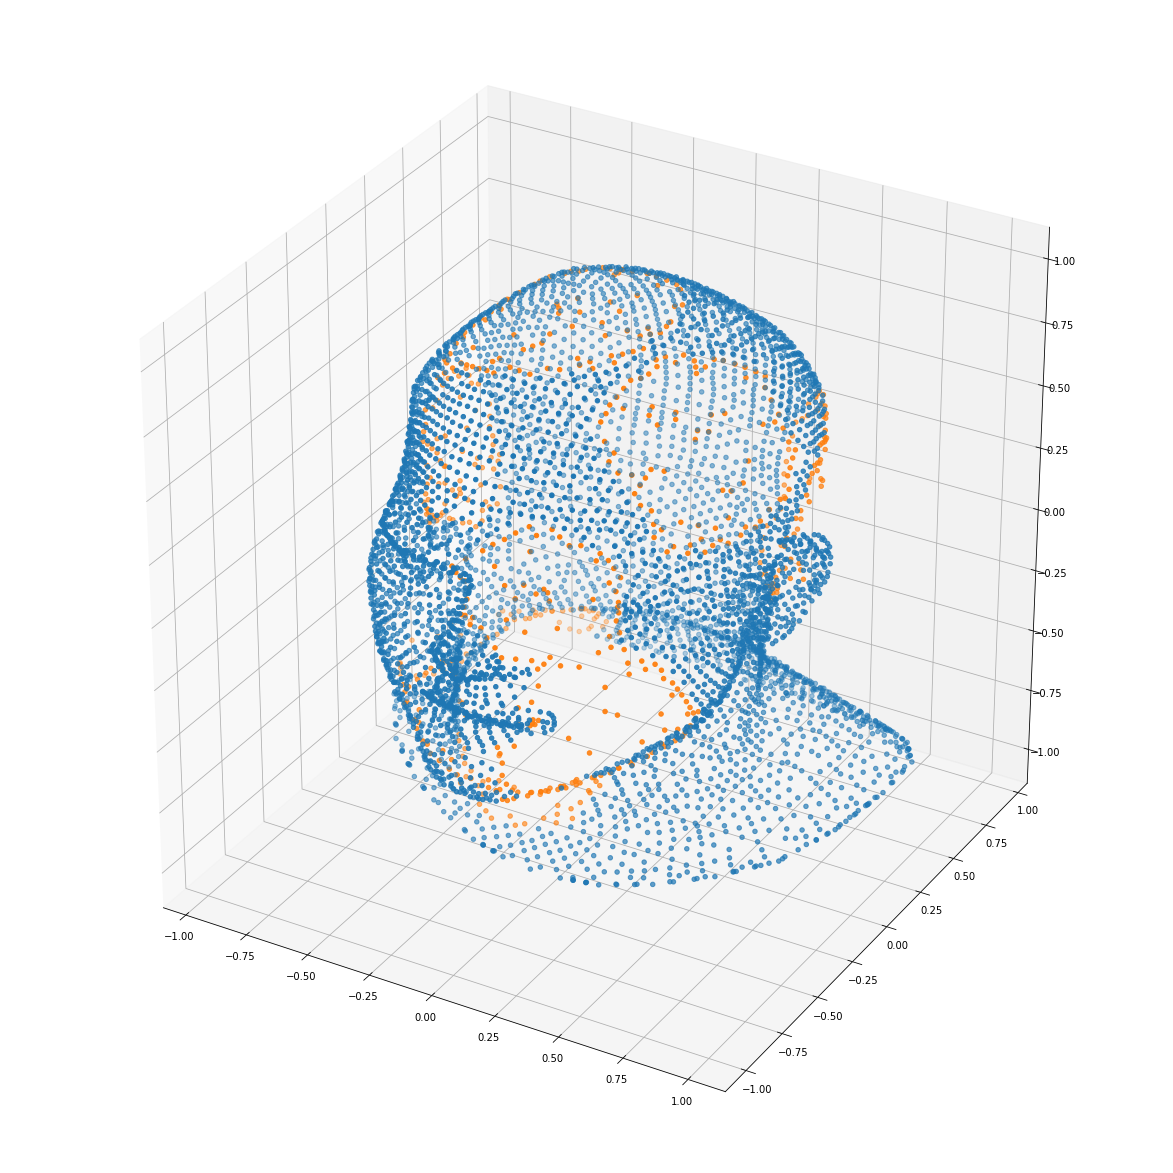

In [10]:
train_data = data["train_bins"]

i = np.random.randint(0, len(train_data))
j = np.random.randint(0, train_data[i].size(0))

sample_Vind = train_data[i][j,:,0]
sample_Emask = train_data[i][j,:,1]

print(sample_Vind.type())
print(sample_Emask.type())

fig = plt.figure(figsize=(16,16))
ax = Axes3D(fig)

edge_pts = pts[sample_Vind][sample_Emask == 1].cpu().numpy()
non_edge_pts = pts[sample_Vind][sample_Emask == 0].cpu().numpy()

print (torch.sum(sample_Emask).item())
print (non_edge_pts.shape)

ax.scatter(non_edge_pts[:,0], non_edge_pts[:,1], non_edge_pts[:,2])
ax.scatter(edge_pts[:,0], edge_pts[:,1], edge_pts[:,2])


plt.show()